# Task 1 - Neural Operators

In this task we are interested in future predictions of the fluid and solid temperature fields. When working with scientific data, there is the possibility of using unsupervised approaches (such as PINNs) and supervised approaches (such as Neural Operators). In this case, we would like to use Neural Operators. The Neural Operator is a supervised learning approach that learns the mapping between the input and output data. The Neural Operator is a neural network that is trained to approximate the solution of a partial differential equation (PDE). The Neural Operator is trained on the data generated by the PDE and is used to predict the future states of the system. The Neural Operator is a powerful tool for solving complex problems in science and engineering. In this task, we will use the Neural Operator to predict the future states of the fluid and solid temperature fields.

## Import libraries

The first activity is to Import libraries from tutorial and pre-existing models. This will allow us to have a better understanding of the code and to use the pre-existing models to solve the problem.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
# torch.manual_seed
import pandas as pd

import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

## Load Data (part 1 with tensor - aborted given there was a rounding problem)

In this case, it would be important to load the data correctly as it would influence our training, and consequently the accuracy of our model. Turning the values to numpy would make the training lose precision, and for this reason, we will use tensors.

In [31]:
# Read the text file
with open('TrainingData.txt', 'r') as file:
    lines = file.readlines()

# Extract column names from the first line
column_names = lines[0].strip().split(',')

# Read the data skipping the first line
data = [line.strip().split(',') for line in lines[1:]]

# Convert data to tensor, excluding non-numeric elements
data_tensor = torch.tensor([[float(cell) for cell in row] for row in data])

print("Output Tensor Shape:", data_tensor.shape)


Output Tensor Shape: torch.Size([210, 3])


In [32]:
# Read the text file
with open('TestingData.txt', 'r') as file:
    lines = file.readlines()

# Extract column names from the first line
column_names = lines[0].strip().split(',')

# Read the data skipping the first line
data = [line.strip().split(',') for line in lines[1:]]

# Convert data to tensor, excluding non-numeric elements
time_predict_tensor = torch.tensor([[float(cell) for cell in row] for row in data])

print("Output Tensor Shape:", time_predict_tensor.shape)


Output Tensor Shape: torch.Size([34, 1])


In [33]:
print(len(data_tensor[:, 0]) + len(time_predict_tensor))

244


I expect 244 values in this case. I have 210 values in the training data and 34 values in the testing data.

In [34]:
# Reshape data_tensor[:, 0] to have the same number of dimensions as time_predict_tensor
data_column_0_expanded = data_tensor[:, 0].unsqueeze(1)

# Concatenate tensors along rows
time_total_tensor = torch.cat((data_column_0_expanded, time_predict_tensor), dim=0)

print("Output Tensor Shape:", time_total_tensor.shape)

Output Tensor Shape: torch.Size([244, 1])


if we analyse the dataset carefully we may notice that 520392.6 - 517914.54 = 2478.06, which is the difference between the last value of the training data and the first value of the testing data. This means that the testing data is a continuation of the training data. We can use this information to concatenate the two datasets.

In [35]:
520392.6 - 517914.54

2478.0599999999977

Given the last simulation may be adapted based on future timepoints, we can also increase the calculated values to include the future timepoints. This will allow us to have more extensive prediction.

In [36]:
added_value = time_total_tensor[-1] + 2478.06

In [37]:
added_value

tensor([604646.6250])

In [38]:
time_total_tensor

tensor([[     0.0000],
        [  2478.0601],
        [  4956.1201],
        [  7434.1802],
        [  9912.2402],
        [ 12390.2998],
        [ 14868.3604],
        [ 17346.4199],
        [ 19824.4805],
        [ 22302.5391],
        [ 24780.5996],
        [ 27258.6602],
        [ 29736.7207],
        [ 32214.7793],
        [ 34692.8398],
        [ 37170.8984],
        [ 39648.9609],
        [ 42127.0195],
        [ 44605.0781],
        [ 47083.1406],
        [ 49561.1992],
        [ 52039.2617],
        [ 54517.3203],
        [ 56995.3789],
        [ 59473.4414],
        [ 61951.5000],
        [ 64429.5586],
        [ 66907.6172],
        [ 69385.6797],
        [ 71863.7422],
        [ 74341.7969],
        [ 76819.8594],
        [ 79297.9219],
        [ 81775.9766],
        [ 84254.0391],
        [ 86732.1016],
        [ 89210.1562],
        [ 91688.2188],
        [ 94166.2812],
        [ 96644.3438],
        [ 99122.3984],
        [101600.4609],
        [104078.5234],
        [10

Writing the whole code. It's also possible to update the pipeline to include the future timepoints.
This can be possible with a for cycle or a function.

In [39]:
# Reshape data_tensor[:, 0] to have the same number of dimensions as time_predict_tensor
data_column_0_expanded = data_tensor[:, 0].unsqueeze(1)

# Concatenate tensors along rows
time_total_tensor = torch.cat((data_column_0_expanded, time_predict_tensor), dim=0)

print("Output Tensor Shape:", time_total_tensor.shape)

# Compute the value to add
added_value_scalar = time_total_tensor[-1] + 2478.06

# Create a tensor containing the value 2478.06 with the same shape as time_total_tensor
value_to_add = torch.full_like(time_total_tensor[0], added_value_scalar.item())

# Concatenate the value_to_add tensor with time_total_tensor along dimension 0
time_total_tensor = torch.cat((time_total_tensor, value_to_add.unsqueeze(0)), dim=0)

print("Updated Time Total Tensor Shape:", time_total_tensor.shape)



Output Tensor Shape: torch.Size([244, 1])
Updated Time Total Tensor Shape: torch.Size([245, 1])


This part can be helpful to idenitfy how are tensor represented. The plan is to have represented in the most effective way given the risk of losing some part of the data due to rounding.

In [40]:
data_tensor[2][2]

tensor(792.1062)

here I want to double check that the value I have is the one I expect, not the rounded version

In [41]:
print("Value at data_tensor[2][2]:", data_tensor[2][2].item())

Value at data_tensor[2][2]: 792.106201171875


The approach used to load the data was suboptimal. For this reason, it may be possible to use another one

In [ ]:
len(time_total_tensor)

NameError: name 'time_total_tensor' is not defined

### Load Data (what has been used)

In [4]:
data_tensor = pd.read_csv("TrainingData.txt")
test_data = pd.read_csv("TestingData.txt")

t_train = data_tensor['t'].to_numpy()
time_predict_tensor = test_data['t'].to_numpy()
time_predict_tensor = np.append(time_predict_tensor, time_predict_tensor[-1]+(time_predict_tensor[1] - time_predict_tensor[0]))
time_total_tensor = np.append(t_train, time_predict_tensor)

# transform all the variables in tensors
time_total_tensor = torch.tensor(time_total_tensor).float()
data_tensor = torch.tensor(data_tensor.to_numpy()).float()

## Create Model

### Handle Data

It's possible to create a code that can normalise and unormalise tensors. In this way, we can transform them on one way or the other depending on our needs.

In [5]:
def normalize_vector(vec):
    """
    Normalize a vector using z-score normalization.

    Args:
        vec (torch.Tensor): Input vector to be normalized.

    Returns:
        torch.Tensor: Normalized vector.
        float: Mean of the input vector.
        float: Standard deviation of the input vector.
    """
    mean = torch.mean(vec)
    std_dev = torch.std(vec)
    normalized_vec = (vec - mean) / std_dev
    return normalized_vec, mean.item(), std_dev.item()

def denormalize_vector(normalized_vec, mean, std_dev):
    """
    Denormalize a normalized vector using mean and standard deviation.

    Args:
        normalized_vec (torch.Tensor): Normalized vector to be denormalized.
        mean (float): Mean of the original vector.
        std_dev (float): Standard deviation of the original vector.

    Returns:
        torch.Tensor: Denormalized vector.
    """
    denormalized_vec = (normalized_vec * std_dev) + mean
    return denormalized_vec

# Example usage:
vec = time_total_tensor
normalised_tensor_time, mean_time, std_dev_time = normalize_vector(time_total_tensor)
print("Normalized vector:", normalised_tensor_time)

# Assuming normalized_vec is your normalized vector
denormalized_tensor_time = denormalize_vector(normalised_tensor_time, mean_time, std_dev_time)
print("Denormalized vector:", denormalized_tensor_time)


Normalized vector: tensor([-1.7215e+00, -1.7074e+00, -1.6933e+00, -1.6791e+00, -1.6650e+00,
        -1.6509e+00, -1.6368e+00, -1.6227e+00, -1.6086e+00, -1.5945e+00,
        -1.5804e+00, -1.5663e+00, -1.5521e+00, -1.5380e+00, -1.5239e+00,
        -1.5098e+00, -1.4957e+00, -1.4816e+00, -1.4675e+00, -1.4534e+00,
        -1.4393e+00, -1.4252e+00, -1.4110e+00, -1.3969e+00, -1.3828e+00,
        -1.3687e+00, -1.3546e+00, -1.3405e+00, -1.3264e+00, -1.3123e+00,
        -1.2982e+00, -1.2840e+00, -1.2699e+00, -1.2558e+00, -1.2417e+00,
        -1.2276e+00, -1.2135e+00, -1.1994e+00, -1.1853e+00, -1.1712e+00,
        -1.1571e+00, -1.1429e+00, -1.1288e+00, -1.1147e+00, -1.1006e+00,
        -1.0865e+00, -1.0724e+00, -1.0583e+00, -1.0442e+00, -1.0301e+00,
        -1.0160e+00, -1.0018e+00, -9.8773e-01, -9.7362e-01, -9.5951e-01,
        -9.4540e-01, -9.3129e-01, -9.1718e-01, -9.0307e-01, -8.8896e-01,
        -8.7485e-01, -8.6074e-01, -8.4663e-01, -8.3252e-01, -8.1840e-01,
        -8.0429e-01, -7.9018e-01

it's possible to do the same also for the other tensors.

In [6]:
Tf_tensor = data_tensor[:, 1]
Ts_tensor = data_tensor[:, 2]
normalised_tensor_Tf, mean_Tf, std_dev_Tf = normalize_vector(Tf_tensor)
normalised_tensor_Ts, mean_Ts, std_dev_Ts = normalize_vector(Ts_tensor)

In [7]:
n_train = 210
batch_dim = 35
batch_size = 2

input_Tf = torch.stack([normalised_tensor_Tf.reshape(-1), normalised_tensor_time[:-35].reshape(-1)], dim=1).reshape(-1, batch_dim, 2)
input_Ts = torch.stack([normalised_tensor_Ts.reshape(-1), normalised_tensor_time[:-35].reshape(-1)], dim=1).reshape(-1, batch_dim, 2)

input_Tf_train = input_Tf[:-1, :]
input_Ts_train = input_Ts[:-1, :]

print("Input Ts train shape: {}".format(input_Ts_train.shape))
print("Input Tf train shape: {}".format(input_Tf_train.shape))

output_Tf_train = input_Tf[1:, :, 0]
output_Ts_train = input_Ts[1:, :, 0]

print("Output Ts train shape: {}".format(output_Tf_train.shape))
print("Output Tf train shape: {}".format(output_Ts_train.shape))

Input Ts train shape: torch.Size([5, 35, 2])
Input Tf train shape: torch.Size([5, 35, 2])
Output Ts train shape: torch.Size([5, 35])
Output Tf train shape: torch.Size([5, 35])


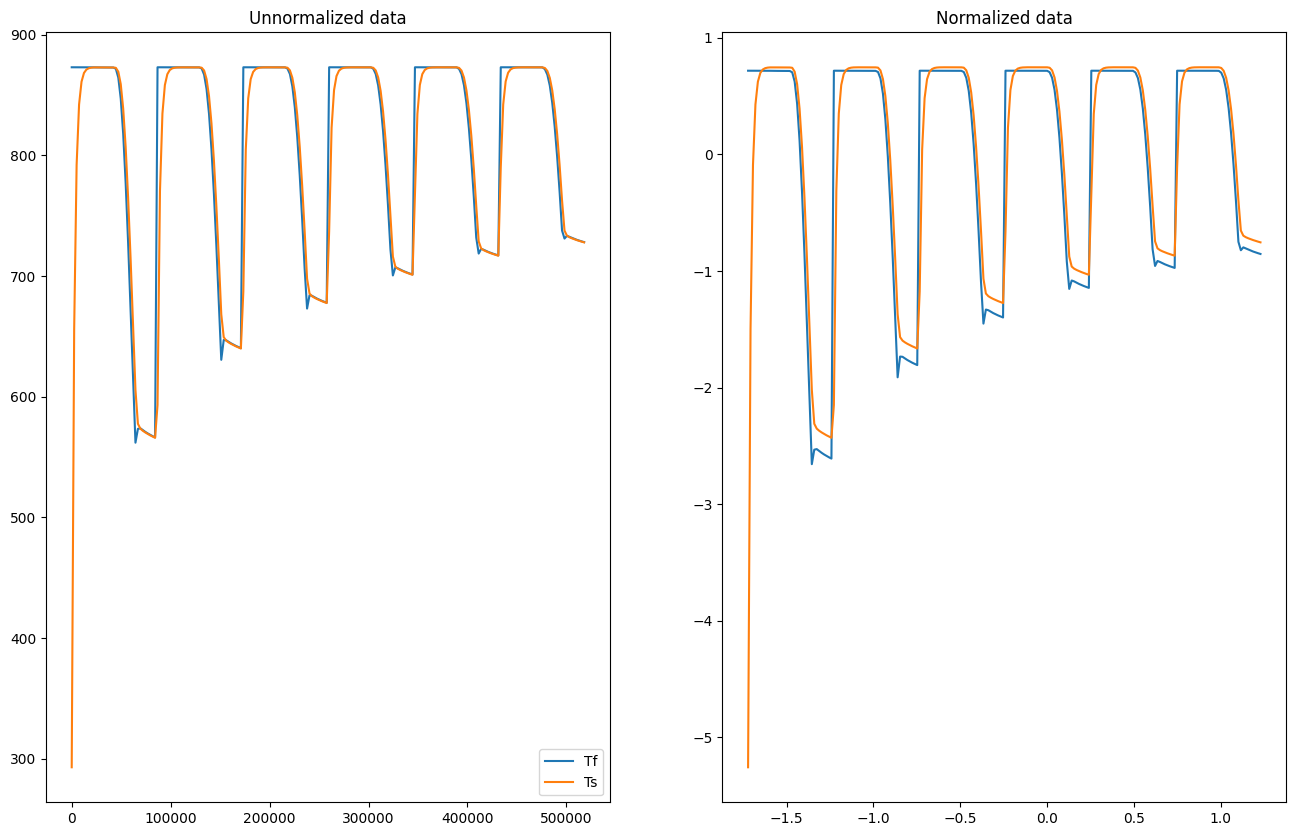

In [8]:
fig, ax = plt.subplots(1,2, figsize = (16, 10))

ax[0].plot(time_total_tensor[:-35], Tf_tensor, label = "Tf")
ax[0].plot(time_total_tensor[:-35], Ts_tensor, label = 'Ts')
ax[0].legend()
ax[0].set_title("Unnormalized data")

ax[1].plot(normalised_tensor_time[:-35], normalised_tensor_Tf, label = 'Tf_normalised')
ax[1].plot(normalised_tensor_time[:-35], normalised_tensor_Ts, label = 'Ts_normalised')
ax[1].set_title("Normalized data")

plt.show()

In the tutorial there was an example using n_train to divide the train data with the test data. However, this approach may not be really helpful given the more data you use, the better the result will be. For this reason, we tend to use all the data for training.

In [9]:
training_set_Tf = DataLoader(TensorDataset(input_Tf_train, output_Tf_train), batch_size=batch_size, shuffle=True)
training_set_Ts = DataLoader(TensorDataset(input_Ts_train, output_Ts_train), batch_size=batch_size, shuffle=True)

In [10]:
# not really useful
#n_train = 210
#batch_dim = 35
#batch_size = 2
#reshaped_input = normalized_data.reshape(-1, batch_dim, 3)
#print("Input Ts train shape: {}".format(reshaped_input.shape))

### 1D FNO Model with two NNs

Note, there could be two possibilities to solve the problem. On the one had there is the possibility of using two NN. On the other hand theree the possibility of using 1D FNO Model with outputs Tf and Ts. # Spectral (or Fourier) layer in 1d
In the second case, there are 3 inputs and 2 outputs

In [11]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')


Considering the type of data we are managing, it's possible to consider a 1D FNO model with two NNs. This model is based on the use of the Fourier layer in 1D. The model has 3 inputs and 2 outputs.

In [12]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform

        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


In [13]:
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)
        x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x

In [14]:
learning_rate = 0.001

epochs = 5000
step_size = 50
gamma = 0.5

modes = 17
width = 128

# Create the model
fno_Tf = FNO1d(modes, width) # gives you the prediction of T_f
fno_Ts = FNO1d(modes, width) # gives you the prediction of T_s

### Train for Tf

In [15]:
optimizer = Adam(fno_Tf.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Lists to store loss values
losses = []

l = torch.nn.MSELoss()
freq_print = 10
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Tf):
        optimizer.zero_grad()
        output_pred_batch = fno_Tf(input_batch).squeeze(2) # gives you the prediction of T_f
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
        # Store loss at each step
        losses.append(loss_f.item())
    train_mse /= len(training_set_Tf)

    scheduler.step()

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse)


######### Epoch: 0  ######### Train Loss: 0.4888206273317337
######### Epoch: 10  ######### Train Loss: 0.019230403937399387
######### Epoch: 20  ######### Train Loss: 0.004864393811052044
######### Epoch: 30  ######### Train Loss: 0.0013815888863367338
######### Epoch: 40  ######### Train Loss: 0.0008949838811531663
######### Epoch: 50  ######### Train Loss: 0.000552221133451288
######### Epoch: 60  ######### Train Loss: 0.00044072385693046573
######### Epoch: 70  ######### Train Loss: 0.00022251446595570693
######### Epoch: 80  ######### Train Loss: 9.204645963715545e-05
######### Epoch: 90  ######### Train Loss: 8.65006028713348e-05
######### Epoch: 100  ######### Train Loss: 4.908593200525502e-05
######### Epoch: 110  ######### Train Loss: 3.0836751951331585e-05
######### Epoch: 120  ######### Train Loss: 3.698141745189787e-05
######### Epoch: 130  ######### Train Loss: 2.45077962972573e-05
######### Epoch: 140  ######### Train Loss: 2.541128454443727e-05
######### Epoch: 150  ####

It's possible ot plot the value of the loss function to see how it behaves. We can also notice the high precision given the use of tensors since the beginning, as the training data would have not handle correctly with the use of numpy.

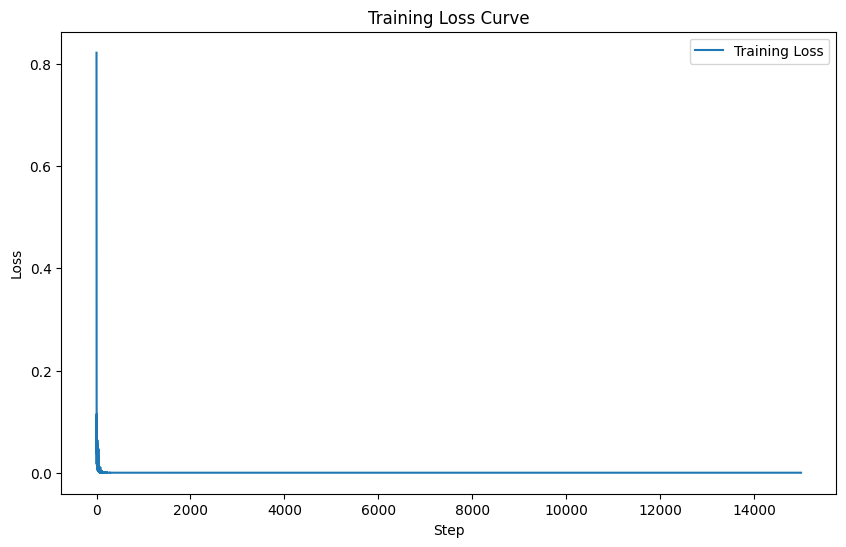

In [16]:
# Plotting the loss curve
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

### Train for Ts

In [17]:
optimizer = Adam(fno_Ts.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 10
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Ts):
        optimizer.zero_grad()
        output_pred_batch = fno_Ts(input_batch).squeeze(2) # gives you the prediction of T_s
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Ts)

    scheduler.step()

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse)

######### Epoch: 0  ######### Train Loss: 0.3735415016611417
######### Epoch: 10  ######### Train Loss: 0.01404788539124032
######### Epoch: 20  ######### Train Loss: 0.0037528508498022952
######### Epoch: 30  ######### Train Loss: 0.0009161963292475169
######### Epoch: 40  ######### Train Loss: 0.0008543421669552723
######### Epoch: 50  ######### Train Loss: 0.0007262678894524773
######### Epoch: 60  ######### Train Loss: 0.00011853934059521028
######### Epoch: 70  ######### Train Loss: 4.398316438406861e-05
######### Epoch: 80  ######### Train Loss: 2.9592104662394075e-05
######### Epoch: 90  ######### Train Loss: 3.677714448713232e-05
######### Epoch: 100  ######### Train Loss: 2.226197072256279e-05
######### Epoch: 110  ######### Train Loss: 1.0932562872767448e-05
######### Epoch: 120  ######### Train Loss: 1.2221006272739032e-05
######### Epoch: 130  ######### Train Loss: 1.20999746589708e-05
######### Epoch: 140  ######### Train Loss: 7.59560142190215e-06
######### Epoch: 150  ##

### Save the weights of the models

In [18]:
torch.save(fno_Tf.state_dict(), 'fno_Tf.pth')
torch.save(fno_Ts.state_dict(), 'fno_Ts.pth')

### Load the weights of the models

In [ ]:
fno_Tf.load_state_dict(torch.load('fno_Tf.pth'))
fno_Ts.load_state_dict(torch.load('fno_Ts.pth'))

### Plot the results

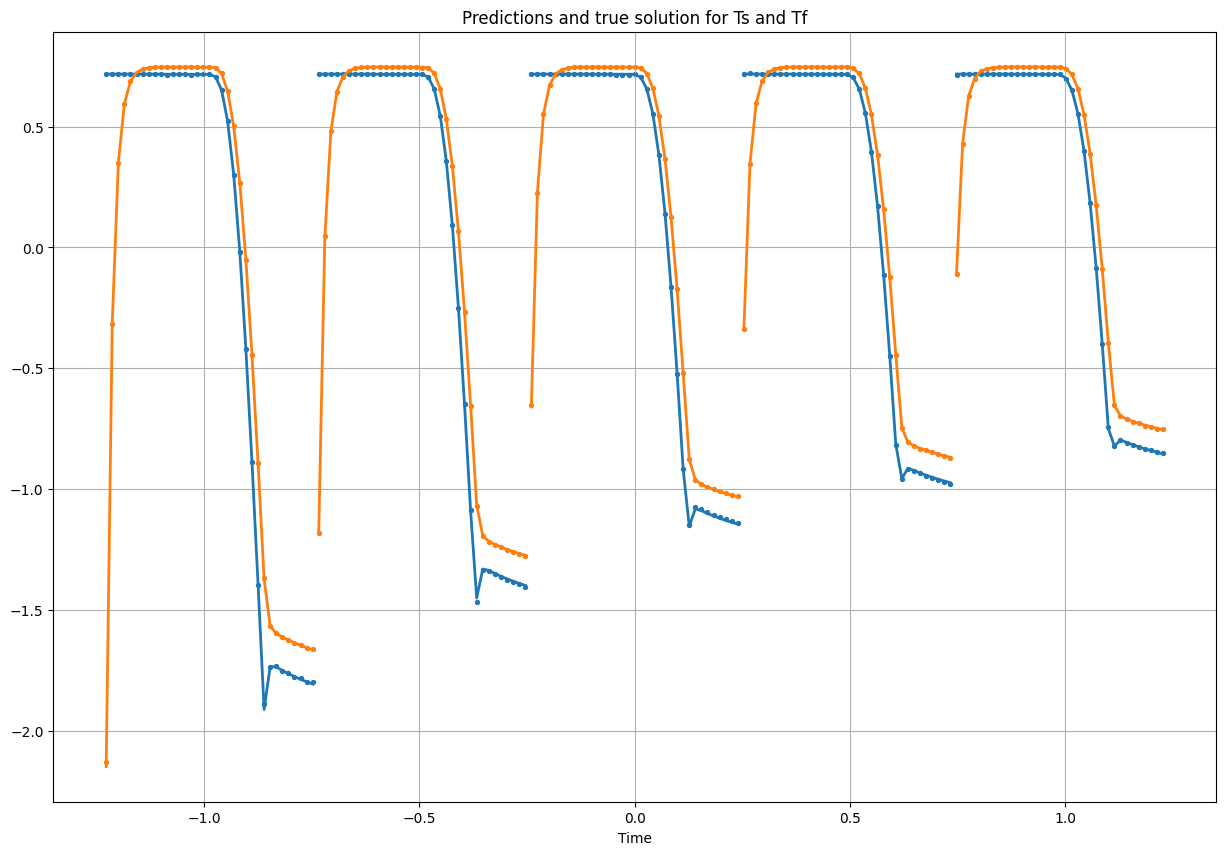

In [19]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
ax.grid()
ax.set_title("Predictions and true solution for Ts and Tf")
ax.set_xlabel("Time")

assert input_Tf.shape[0] == input_Ts.shape[0]

for i in range(input_Tf_train.shape[0]):

    input_function_test_Tf = input_Tf_train[i, :].unsqueeze(0)
    output_function_test_Tf = output_Tf_train[i, :].unsqueeze(0)

    input_function_test_Ts = input_Ts_train[i, :].unsqueeze(0)
    output_function_test_Ts = output_Ts_train[i, :].unsqueeze(0)

    output_function_test_pred_Tf = fno_Tf(input_function_test_Tf)
    output_function_test_pred_Ts = fno_Ts(input_function_test_Ts)

    ax.plot(input_Tf[i+1, :][:, 1].detach(), output_function_test_Tf[0].detach(), label="True Solution", c="C0", lw=2)
    ax.scatter(input_Tf[i+1, :][:, 1].detach(), output_function_test_pred_Tf[0].detach(), label="Approximate Solution", s=8, c="C0")

    ax.plot(input_Ts[i+1, :][:, 1].detach(), output_function_test_Ts[0].detach(), label="True Solution", c="C1", lw=2)
    ax.scatter(input_Ts[i+1, :][:, 1].detach(), output_function_test_pred_Ts[0].detach(), label="Approximate Solution", s=8, c="C1")
    # print()
# ax.legend()
plt.show()

In [20]:
input_Tf_train.shape

torch.Size([5, 35, 2])

In [21]:
fontsize = 16
markersize = 3

input_Tf_pred = input_Tf[-1, :].unsqueeze(0)
input_Ts_pred = input_Ts[-1, :].unsqueeze(0)


Prediction

In [22]:
output_pred_Tf = fno_Tf(input_Tf_pred).squeeze()
output_pred_Ts = fno_Ts(input_Ts_pred).squeeze()

Invert data to get unnormalized results

In [23]:
# Prediction on the test data in the original scale
output_pred_Tf_org = denormalize_vector(output_pred_Tf, mean_Tf, std_dev_Tf)
output_pred_Ts_org = denormalize_vector(output_pred_Ts, mean_Ts, std_dev_Ts)


output_pred_Tf_train = fno_Tf(input_Tf_train)
output_pred_Ts_train = fno_Ts(input_Ts_train)

In [24]:
len(output_pred_Tf_org)

35

In [25]:
output_pred_Tf_org

tensor([871.3986, 871.1378, 871.3768, 871.7084, 871.8184, 872.1141, 872.0841,
        872.1804, 872.1360, 872.5781, 872.3427, 872.4637, 872.2981, 872.3072,
        871.8438, 871.6870, 871.3745, 871.4461, 869.2816, 864.7674, 856.0192,
        842.4708, 824.0407, 800.6749, 773.4690, 744.2751, 741.9611, 742.6216,
        741.6385, 740.9379, 740.2471, 739.7916, 739.4098, 739.1460, 738.9228],
       grad_fn=<AddBackward0>)

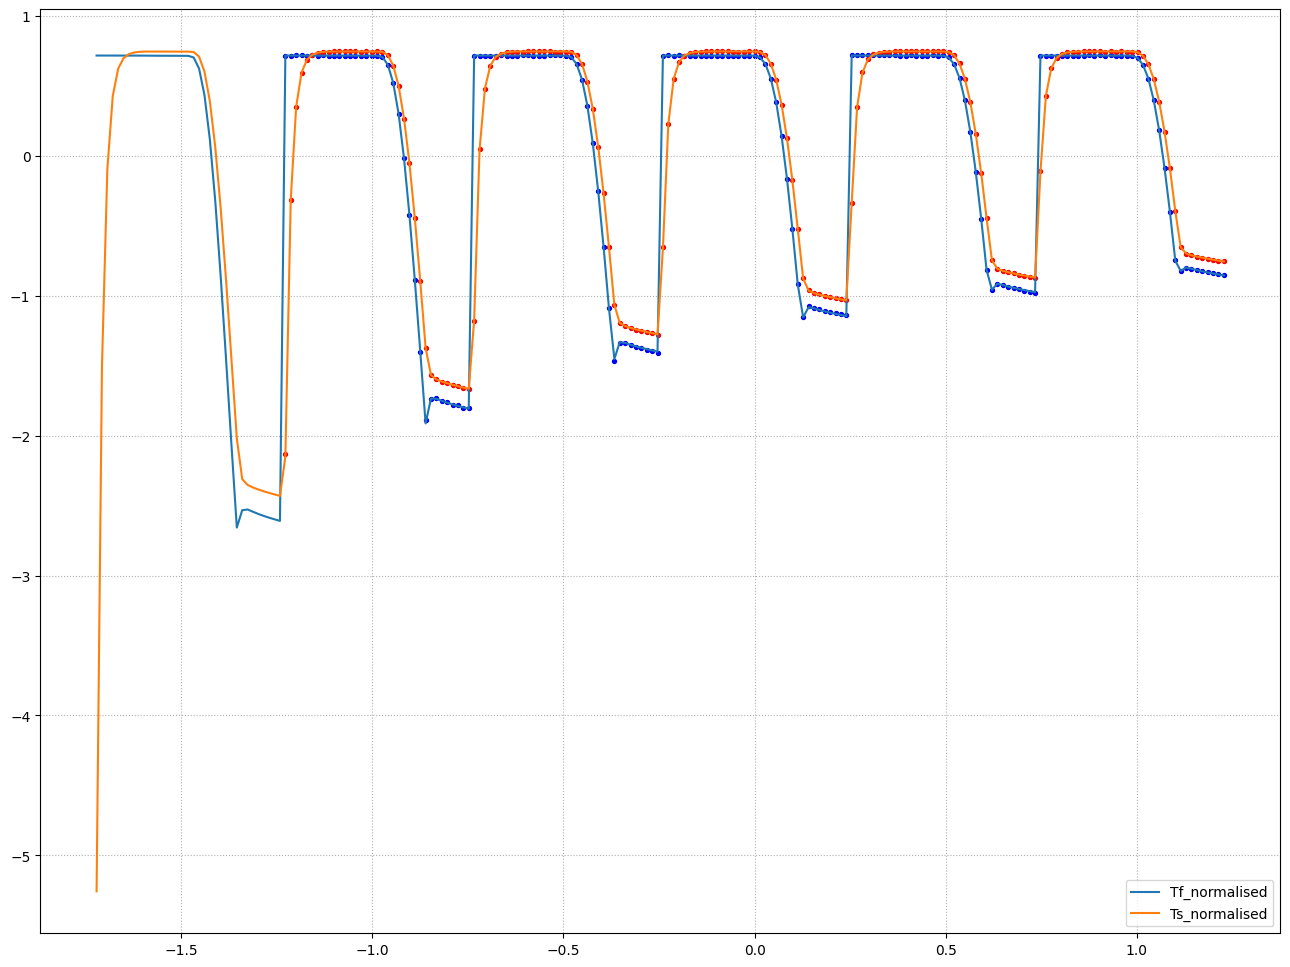

<Figure size 1600x1200 with 0 Axes>

In [26]:
fig, ax = plt.subplots(1,1, figsize = (16, 12))
plt.grid(True, which="both", ls=":")
com_div = 35
plt.figure(dpi=250)

batch_size = 35
for i in range(input_Tf_train.shape[0]):
    input_function_n_tf = input_Tf_train[i, :].unsqueeze(0)
    output_pred_tf_n = fno_Tf(input_function_n_tf)
    ax.scatter(input_Tf.reshape(-1,2)[(i+1)*batch_size:(i+1)*batch_size+batch_size, 1].detach(), output_pred_tf_n[0].detach(), s=8, c="blue")

for i in range(input_Ts_train.shape[0]):
    input_function_n_ts = input_Ts_train[i, :].unsqueeze(0)
    output_pred_ts_n = fno_Ts(input_function_n_ts)
    ax.scatter(input_Ts.reshape(-1,2)[(i+1)*batch_size:(i+1)*batch_size+batch_size, 1].detach(), output_pred_ts_n[0].detach(), s=8, c="red")

ax.plot(normalised_tensor_time[:-35], normalised_tensor_Tf, label = 'Tf_normalised')
ax.plot(normalised_tensor_time[:-35], normalised_tensor_Ts, label = 'Ts_normalised')
# ax.plot(t_train_norm, Ts0_norm, label = 'ts_norm')
# ax.set_title("Normalized data")
ax.legend()

plt.show()

### Save the data

In [29]:
pred_Tf_save = output_pred_Tf_org[:-1].reshape(-1)
pred_Ts_save = output_pred_Ts_org[:-1].reshape(-1)
t_save = time_total_tensor[210:-1]

In [32]:
pred_Ts_save

tensor([805.0211, 847.0212, 861.9657, 866.5869, 869.8900, 870.7602, 871.6293,
        871.7878, 872.0689, 872.1916, 872.2538, 871.8479, 871.7058, 871.9622,
        871.8916, 872.0842, 871.7136, 871.6628, 870.7697, 867.9537, 861.6703,
        851.9366, 837.2085, 817.7068, 793.5515, 766.1026, 745.1508, 741.7380,
        741.1094, 739.8701, 739.6488, 738.3802, 738.3178, 737.7064],
       grad_fn=<ViewBackward0>)

In [33]:
# Detach and convert tensors to NumPy arrays
data = {
    't': t_save.detach().numpy(),
    'tf0': pred_Tf_save.detach().numpy(),
    'ts0': pred_Ts_save.detach().numpy()
}

# Create DataFrame
df_save = pd.DataFrame(data)
df_save.to_csv('results.txt', index=False)

In [74]:
''''# Open a file for writing
with open('results.txt', 'w') as file:
    # Write column headers
    file.write("t,tf0,ts0\n")

    # Iterate through the data and write each row
    for i in range(len(t_save)):
        file.write(f"{t_save[i].item()},{pred_Tf_save[i].item()},{pred_Ts_save[i].item()}\n")
'''

In [73]:
print("Value at data_tensor[2][2]:", pred_Ts_save[0].item())

Value at data_tensor[2][2]: 805.9291381835938


The usage of tensors in this exercise has been useful as it allowed us not to lose precision. However, the rouding problem didn't allowed us to measure data precisely as wanted. So, even though the code may be correct and well performing, the initial part where managing tensors may not give a perfect and clean reasult